In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.applications import Xception

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224

# Re-loads the MobileNet model without the top or FC layers
Xception = Xception(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))


# # Layers are set to trainable as True by default
# for layer in Xception.layers:
#     layer.trainable = True

# # Let's print our layers
# for (i,layer) in enumerate(Xception.layers):
#     print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer True
1 Conv2D True
2 BatchNormalization True
3 Activation True
4 Conv2D True
5 BatchNormalization True
6 Activation True
7 SeparableConv2D True
8 BatchNormalization True
9 Activation True
10 SeparableConv2D True
11 BatchNormalization True
12 Conv2D True
13 MaxPooling2D True
14 BatchNormalization True
15 Add True
16 Activation True
17 SeparableConv2D True
18 BatchNormalization True
19 Activation True
20 SeparableConv2D True
21 BatchNormalization True
22 Conv2D True
23 MaxPooling2D True
24 BatchNormalization True
25 Add True
26 Activation True
27 SeparableConv2D True
28 BatchNormalization True
29 Activation True
30 SeparableConv2D True
31 BatchNormalization True
32 Conv2D True
33 MaxPooling2D True
34 BatchNormalization True
35 Add True
36 Activation True
37 SeparableConv2D True
38 BatchNormalization True
39 Activation True
40 SeparableConv2D True
41 BatchNormalization True
42 Activation True
43 SeparableConv2D True
44 BatchNormalization True
45 Add True
46 Activation True
47

In [ ]:
def addTopModelXception(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model

# Set our class number to 3 (Young, Middle, Old)
num_classes = 2

FC_Head = addTopModelXception(Xception, num_classes)

model = Model(inputs = Xception.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/MyDrive/catvsdog/training_set/training_set'
validation_data_dir = '/content/drive/MyDrive/catvsdog/test_set/test_set'

# Let's use some data augmentaiton
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 20

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping


# We use a very small learning rate
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 8005
nb_validation_samples = 2023

# We only train 5 EPOCHS
epochs = 20
batch_size = 20

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)
model.save("/content/drive/My Drive/dognewdataset_mobileNetfinal20.h5")

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-13-194bd2fcf5a1>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2
400/400 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8808

In [ ]:
model.save('/content/drive/MyDrive/catvsdog/cat_dog.h5')

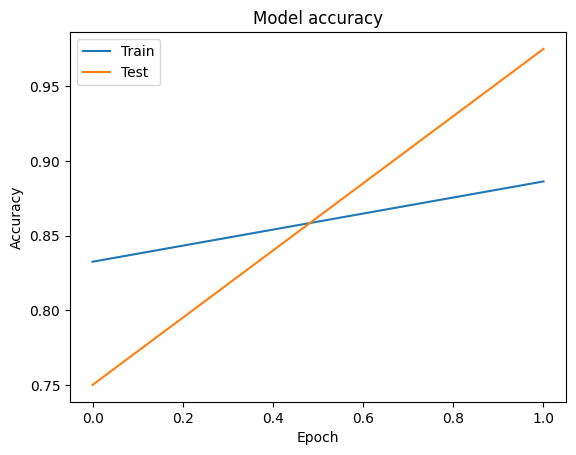

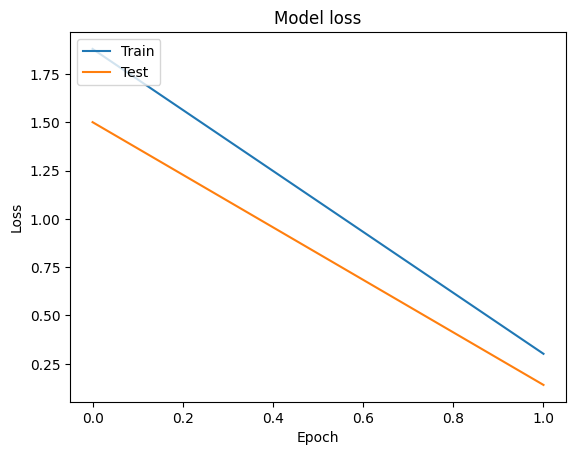

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 8005
nb_validation_samples = 2023

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

Found 2023 images belonging to 2 classes.


<ipython-input-9-1dad908acc37>:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)


Confusion Matrix


ValueError: ignored

In [ ]:
import numpy as np
import cv2
from keras.preprocessing import image
from keras.models import load_model
model= load_model('/content/drive/My Drive/dognewdataset_mobileNetfinal20.h5')
def predict_one_image(img, model):
  img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_CUBIC)
  img = np.reshape(img, (1, 224, 224, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

n02112018-Pomeranian 100%


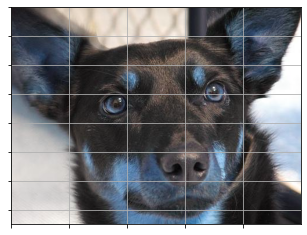

In [ ]:
import cv2
import os
from matplotlib import pyplot as plt
datas=os.listdir("/content/drive/My Drive/dog7525new/test_set")
test_img = cv2.imread('/content/drive/My Drive/dog7525new/test_set/n02105412-kelpie/n02105412_1952.jpg')
pred, probability = predict_one_image(test_img,model)
if probability > 0.7:
    print('%s %d%%' % (datas[pred], round(probability, 2) * 100))
    _, ax = plt.subplots(1)
    plt.imshow(test_img)
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.grid('off')
    plt.show()
else:
     print("This is not a dog" )
     plt.imshow(test_img)




In [ ]:
import numpy as np
np.argmax(np.array([42,33]))

In [ ]:
A B C D